# 2주차: 신경망 모델링 & 학습 루프

## 참고자료
- [PyTorch CIFAR-10 튜토리얼](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)  
- Stanford CS231n 강의 노트 중 CNN 챕터

In [1]:
## 1. 환경 설정 및 데이터 준비
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
4
# %% [code]
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 데이터 전처리: Tensor 변환 및 정규화
transform = transforms.Compose([ #transforms.Compose는 여러 개의 변환을 연속적으로 적용할 수 있게 해줌
    transforms.ToTensor(), # PIL 이미지 또는 numpy 배열을 Tensor로 변환
    transforms.Normalize((0.5,), (0.5,))  # MNIST는 흑백이므로 채널 하나
])

In [3]:
# MNIST 학습/검증 데이터셋 로딩
train_set = torchvision.datasets.MNIST(root='./data',
                                       train=True,
                                       download=True,
                                       transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=64,
                                           shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1000,
                                          shuffle=False)


## PyTorch의 nn.Module 이해하기

`nn.Module`은 PyTorch에서 신경망 모델을 구성하는 기본 클래스입니다. 모든 신경망 모델은 이 클래스를 상속받아 구현됩니다.

### nn.Module의 주요 특징

1. **계층적 구조**: 모듈 안에 다른 모듈을 중첩해서 포함할 수 있습니다.
2. **자동 파라미터 관리**: `parameters()` 메소드를 통해 모델의 모든 학습 가능한 파라미터에 쉽게 접근할 수 있습니다.
3. **forward 메소드**: 모델의 순전파(forward pass) 연산을 정의하는 메소드로, 반드시 구현해야 합니다.
```python
class Module:
    def __init__(self):
        # 1. 파라미터 관리 시스템
        self._parameters = OrderedDict()  # 학습 가능한 파라미터 저장
        self._buffers = OrderedDict()     # 상태 저장용 버퍼 (예: BatchNorm의 running_mean)
        self._modules = OrderedDict()     # 하위 모듈 저장
        self.training = True              # 학습/추론 모드 플래그

    # 2. 파라미터 등록 메커니즘
    def register_parameter(self, name: str, param: Parameter):
        """학습 가능한 파라미터 등록"""
        if param is not None:
            self._parameters[name] = param  # 실제로 optim에 의해 업데이트됨

    # 3. 서브모듈 관리 시스템  
    def add_module(self, name: str, module: 'Module'):
        """계층 구조 구성 핵심 메서드"""
        self._modules[name] = module  # 재귀적 모델 구성 가능

    # 4. Forward/Backward 처리 
    def forward(self, *input):
        raise NotImplementedError("Must implement forward()")  # 사용자가 반드시 구현

    def __call__(self, *input, **kwargs):
        # 실제 연산 시작 전/후 훅 호출
        for hook in self._forward_pre_hooks.values():
            hook(self, input)
        result = self.forward(*input, **kwargs)  # 실제 연산 실행
        for hook in self._forward_hooks.values():
            hook(self, input, result)
        return result

    # 5. 장치 관리 시스템
    def to(self, device):
        """모델 전체를 지정한 장치로 이동"""
        def apply_fn(module):
            for param in module.parameters():
                param.data = param.data.to(device)
            for buf in module.buffers():
                buf.data = buf.data.to(device)
        return self.apply(apply_fn)  # 재귀적 적용

    # 6. 상태 저장/불러오기
    def state_dict(self):
        """모델 상태 저장"""
        state_dict = {}
        # 모든 파라미터와 버퍼 수집
        for name, param in self.named_parameters():
            state_dict[name] = param.data
        for name, buf in self.named_buffers():
            state_dict[name] = buf.data
        return state_dict

    # 7. 재귀적 처리 시스템
    def apply(self, fn):
        """모든 서브모듈에 함수 적용"""
        fn(self)
        for module in self.children():
            module.apply(fn)  # 재귀 호출
        return self
```



In [4]:
# MNIST 분류기 모델 정의
class MNISTClassifier(nn.Module): # nn.Module을 상속받아 모델 클래스를 정의
    def __init__(self):
        super(MNISTClassifier, self).__init__() # 부모 클래스 초기화
        # 간단한 Fully-Connected 신경망: 입력 784 → 은닉층 128 → 출력 10
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # x: [batch_size, 1, 28, 28] → [batch_size, 784]
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)
        return logits


In [5]:
# 모델 인스턴스 생성 및 디바이스 이동
model = MNISTClassifier().to(device)

# 3. 학습 루프 구현 및 학습 곡선 시각화

- **모델, 손실함수, 옵티마이저 설정**  
- **각 Epoch와 Batch마다**  
  1. 입력 데이터 형태 확인  
  2. 순전파 결과(로짓) 확인  
  3. Softmax 확률 및 예측 클래스 확인  
  4. 샘플별 손실과 배치 평균 손실 확인  
  5. 역전파 후 특정 파라미터의 그래디언트 분포 확인  
  6. 가중치 업데이트 전후 간단 비교  
- 학습이 어떻게 진행되는지 단계별로 출력하여 이해를 돕습니다.

In [6]:
train_set[0] # 이미지 데이터, 클래스

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [7]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

# # train_set, model, device는 이미 정의되어 있다고 가정합니다.

# batch_size = 16  # 배치 크기 지정
# train_loader = DataLoader(
#     train_set,            # 학습용 데이터셋
#     batch_size=batch_size,  # 한 배치에 사용할 데이터 수
#     shuffle=True,           # 에포크마다 데이터 섞기
#     num_workers=0           # 데이터 로딩에 사용할 서브 프로세스 개수 (여기선 단일)
# )

# criterion = nn.CrossEntropyLoss()                 # 다중 클래스 분류 손실 함수
# optimizer = optim.SGD(model.parameters(), lr=0.01) # SGD 옵티마이저, 학습률 0.01
# num_epochs = 5                                    # 전체 학습 반복 횟수

# for epoch in range(num_epochs):
#     model.train()            # 모델을 학습 모드로 설정 (드롭아웃, 배치정규화 동작)
#     running_loss, correct, total = 0.0, 0, 0  # 누적 손실, 정답 개수, 전체 샘플 수 초기화

#     for images, labels in train_loader:        # 배치 단위로 데이터 로드
#         images, labels = images.to(device), labels.to(device)  # GPU 또는 CPU로 데이터 이동

#         optimizer.zero_grad()                  # 기울기(gradient) 초기화
#         outputs = model(images)                # 모델에 입력하여 예측값(로짓) 계산
#         loss = criterion(outputs, labels)      # 손실(loss) 계산
#         loss.backward()                        # 손실에 대해 역전파 수행 (기울기 계산)
#         optimizer.step()                       # 모델 파라미터 업데이트

#         _, preds = torch.max(outputs, 1)       # 예측 클래스(최댓값 인덱스) 추출
#         running_loss += loss.item() * labels.size(0)   # 전체 손실 합산
#         correct += preds.eq(labels).sum().item()       # 맞은 개수 누적
#         total += labels.size(0)                         # 전체 샘플 개수 누적

#     epoch_loss = running_loss / total       # 에포크 평균 손실
#     epoch_acc = correct / total             # 에포크 평균 정확도
#     print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.4f}")  # 결과 출력


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader  # DataLoader 재정의 필요
# (이미 train_dataset이 정의되어 있다고 가정)

# 0) 배치 사이즈 조정: 메모리 안정화를 위해 작게 설정
small_batch_size = 16
train_loader = DataLoader(
    train_set,
    batch_size=small_batch_size,
    shuffle=True,
    num_workers=0  # 워커 없이 단일 프로세스로 로딩
)

# 1) 손실함수와 옵티마이저 정의
criterion_none = nn.CrossEntropyLoss(reduction='none')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 5  # 전체 Epoch 수

train_losses, train_accs = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f"\n--- Epoch {epoch}/{num_epochs} 시작: batch_size={small_batch_size} ---")
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        if batch_idx == 0:
            print(f"[Batch {batch_idx}] images.shape = {images.shape}, labels.shape = {labels.shape}")

        optimizer.zero_grad()
        outputs = model(images)
        if batch_idx == 0:
            print(" 로짓 예시 (첫 5개 샘플):")
            print(outputs[:5].detach().cpu().numpy())

        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        if batch_idx == 0:
            print(" 소프트맥스 확률 예시 (첫 5개 샘플):")
            print(probs[:5].detach().cpu().numpy())
            print(" 예측 클래스 예시:", preds[:5].detach().cpu().numpy())
            print(" 실제 레이블 예시:", labels[:5].detach().cpu().numpy())

        sample_losses = criterion_none(outputs, labels)
        loss = criterion(outputs, labels)
        if batch_idx == 0:
            print(" 샘플별 손실 (첫 5개):", sample_losses[:5].detach().cpu().numpy())
            print(f" 배치 평균 손실: {loss.item():.4f}")

        loss.backward()
        if batch_idx == 0:
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    grad = param.grad.detach()
                    print(f" 그래디언트 '{name}' 평균={grad.mean():.4f}, 표준편차={grad.std():.4f}")
                    break

        if batch_idx == 0:
            before = param.data.view(-1)[0].item()
        optimizer.step()
        if batch_idx == 0:
            after = param.data.view(-1)[0].item()
            print(f" 파라미터 '{name}' 업데이트 전={before:.6f}, 후={after:.6f}")

        running_loss += loss.item() * labels.size(0)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f">>> Epoch {epoch} 완료: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")


--- Epoch 1/5 시작: batch_size=16 ---
[Batch 0] images.shape = torch.Size([16, 1, 28, 28]), labels.shape = torch.Size([16])
 로짓 예시 (첫 5개 샘플):
[[-0.23456526 -0.37651622 -0.6358827   0.44793618 -0.28512022  0.19066638
  -0.17512271  0.21634793  0.06895867 -0.03570519]
 [-0.13004255 -0.3426296  -0.5428936   0.5060077  -0.12257197  0.20477998
   0.1158677   0.09805023  0.10104321  0.13435246]
 [-0.28740513 -0.19725652 -0.5090355   0.5633339  -0.12938508  0.00772224
  -0.15122202  0.01211481  0.01892412  0.29402423]
 [-0.21442762 -0.35364568 -0.36967516  0.29940084 -0.3437745   0.38955367
   0.13345411  0.0820866   0.07671701  0.19685882]
 [-0.22498767 -0.40811473 -0.44355494  0.60448104 -0.18129155  0.13705158
   0.05693479  0.05007038  0.08775424  0.16810283]]
 소프트맥스 확률 예시 (첫 5개 샘플):
[[0.08195247 0.07110719 0.05486206 0.16216931 0.07791235 0.12538275
  0.08697163 0.12864448 0.11101478 0.09998293]
 [0.08430251 0.06815773 0.0557881  0.15924786 0.08493466 0.11782897
  0.10780478 0.10590097 0.

C:\Users\howsr\AppData\Local\Temp\ipykernel_42028\3492019947.py:26: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\howsr\miniconda3\envs\ForTorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


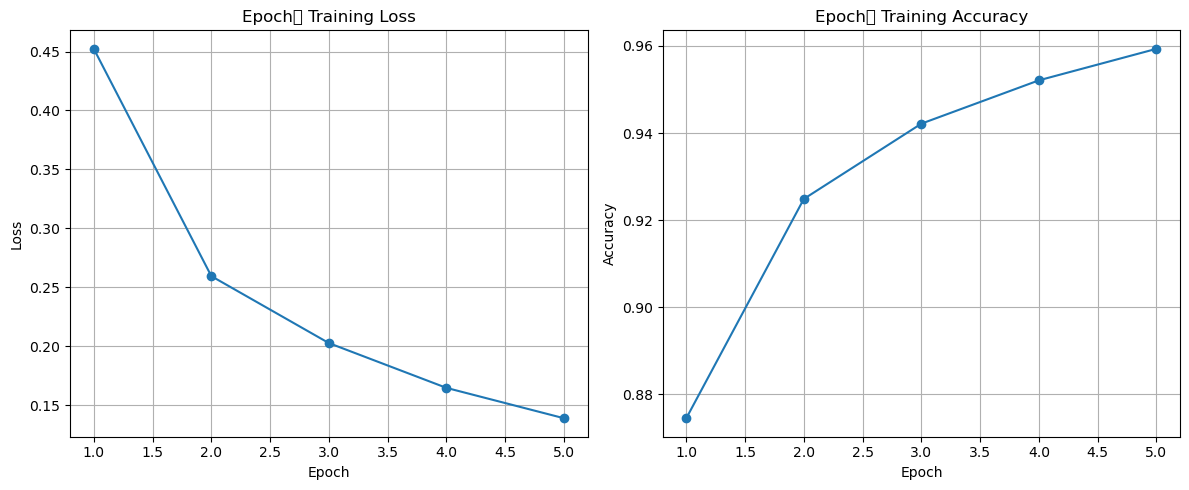

: 

In [ ]:
import matplotlib.pyplot as plt

# 1) Epoch 번호 리스트 생성 (1부터 num_epochs까지)
epochs = list(range(1, len(train_losses) + 1))

# 2) Figure 크기 설정 (가로 12인치, 세로 5인치)
plt.figure(figsize=(12, 5))

# --- 서브플롯 1: Training Loss ---
plt.subplot(1, 2, 1)                       # 1행 2열 중 첫 번째 위치
plt.plot(epochs, train_losses, marker='o') # 점 표시 마커
plt.title('Epoch별 Training Loss')        # 그래프 제목
plt.xlabel('Epoch')                        # x축 라벨
plt.ylabel('Loss')                         # y축 라벨
plt.grid(True)                             # 격자 표시

# --- 서브플롯 2: Training Accuracy ---
plt.subplot(1, 2, 2)                         # 1행 2열 중 두 번째 위치
plt.plot(epochs, train_accs, marker='o')
plt.title('Epoch별 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 3) 레이아웃 자동 조정 후 출력
plt.tight_layout()
plt.show()
